In [162]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

NMSE = 'neg_mean_squared_error'

In [322]:
#####
# PART - I : Data Import & Cleaning & Transformation
#####

df = pd.read_csv('communities.csv')
n_row, n_col = df.shape
print('(1) Data Shape: {:d} samples & {:d} features.'.format(n_row, n_col))

miss_stat = df.isnull().sum()  # Series
print('\n(2) Missing values counts in each column:\n', 
      miss_stat.value_counts().to_frame(name='freq'))

# columns with multiple missing value (almost over 2/3 NaN, indeed) shall not be used
predictors = [col for col, f in miss_stat.iteritems() if f <= 1]

# delete special columns (response, fold, county & state names, etc.)
response_name = 'ViolentCrimesPerPop'
predictors.remove('communityname')
predictors.remove('fold')
predictors.remove(response_name)

# filter out the row with one missing value
missed_col = miss_stat[miss_stat == 1].index
df = df.loc[~np.isnan(df[missed_col].values.transpose()[0]), :]

# split X & y, train & test sets
row_sel = df['fold'] == 1
X_test, y_test = df.loc[row_sel, predictors], df.loc[row_sel, response_name].values
row_sel = df['fold'] != 1
X_train, y_train = df.loc[row_sel, predictors], df.loc[row_sel, response_name].values

n_row, n_col = X_train.shape
print('\n(3) X_train shape after transformation: {:d} samples & {:d} features.'
      .format(n_row, n_col))
predictors = np.array(predictors)

(1) Data Shape: 1994 samples & 128 features.

(2) Missing values counts in each column:
       freq
0      103
1675    22
1177     1
1174     1
1        1

(3) X_train shape after transformation: 1794 samples & 101 features.


In [323]:
#####
# PART - II : Model Training & Model Selection
#####

# PART - 2.1 : Linear Regression
# ==============================

model_lr = LinearRegression(normalize=True)
model_lr.fit(X_train, y_train)
mse_lr = mean_squared_error(y_test, model_lr.predict(X_test))
print('(1) MSE of LR:', mse_lr)
pred_rank_lr = [pname for pname, _ in sorted(zip(predictors, model_lr.coef_), 
                key=lambda x: abs(x[1]), reverse=True)][:10]
print('\n(2) 10 Most Important Predictors (descending):\n\t', pred_rank_lr)

(1) MSE of LR: 0.0209962471269

(2) 10 Most Important Predictors (descending):
	 ['PersPerOccupHous', 'TotalPctDiv', 'PctPersOwnOccup', 'PctHousOwnOcc', 'MalePctDivorce', 'OwnOccLowQuart', 'numbUrban', 'MedRent', 'PctKids2Par', 'OwnOccMedVal']


MSE of Decision Tree: 0.0264353888497


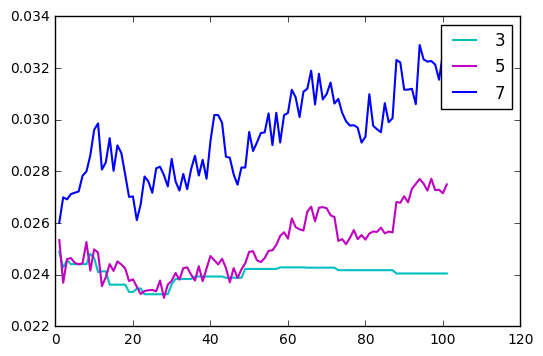


Optimal n_feature = 28, optimal MSE = 0.023108

Predictors:
 ['PctIlleg', 'PctKids2Par', 'PctFam2Par', 'racePctWhite', 'PctYoungKids2Par', 'PctTeen2Par', 'racepctblack', 'pctWPubAsst', 'pctWInvInc', 'FemalePctDiv', 'TotalPctDiv', 'PctPopUnderPov', 'PctPersOwnOccup', 'MalePctDivorce', 'PctUnemployed', 'PctVacantBoarded', 'PctHousNoPhone', 'PctNotHSGrad', 'PctHousLess3BR', 'PctHousOwnOcc', 'NumIlleg', 'PctPersDenseHous', 'NumUnderPov', 'medFamInc', 'medIncome', 'HousVacant', 'PctLess9thGrade', 'PctLargHouseFam']


In [325]:
# PART - 2.2 : Decision Tree
# ===========================
# PART - 2.2.1: Default Model 

model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(X_train, y_train)
mse_tree = mean_squared_error(y_test, model_tree.predict(X_test))
print('MSE of Decision Tree:', mse_tree)

# PART - 2.2.2 : Model Selection
# First, rank each feature by their F-value to targets in descendant order.
Fval, pval = f_regression(X_train, y_train)
ranked_features = [pname for pname, _ in sorted(zip(predictors, Fval), 
                                                key=lambda x: x[1], reverse=True)]

# For each possible hyper-parameter max_depth's value in tree model, 
# do feature selection separately and plot the corresponding MSE scores.
opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for max_depth, color in ((3, 'c'), (5, 'm'), (7, 'b')):
    estimator = DecisionTreeRegressor(max_depth=max_depth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=5).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(max_depth))
plt.legend(loc='upper right')
plt.show()
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))
print('\nPredictors:\n', ranked_features[:opt_n_feature])

# PART - 2.2.3 : Summary
# The basic tree model achieves a MSE = 2.64e-2, 
# while after trying out different selection of max_depth, 
# we settle down on using max_depth=5 & 28 most relevant features as printed below,
# achieved a better MSE at 2.32e-2.
# It is easy to see that on a smaller set of features, max_depth=3 & 5 performs similar,
# while when more predictors are introduced to the model, deeper trees tend to get over-fitted.

MSE of Random Forest: 0.0258121945595



Optimal n_feature = 38, optimal MSE = 0.019233


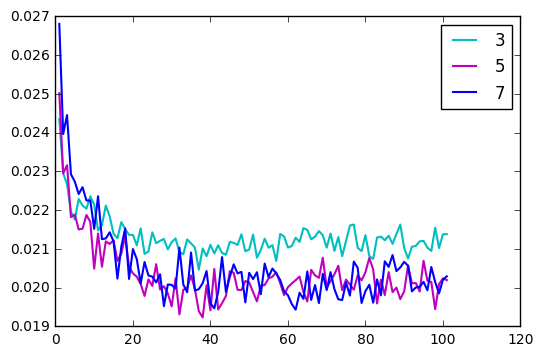

In [343]:
# PART - 2.3 : Random Forest
# ===========================
# PART - 2.3.1: Default Model

model_forest = RandomForestRegressor(n_estimators=10, max_depth=3)  # default setting
model_forest.fit(X_train, y_train)
mse_forest = mean_squared_error(y_test, model_forest.predict(X_test))
print('MSE of Random Forest:', mse_forest)

# PART - 2.3.2 : Model Selection (Basic)
# As we already have features ranked by their F-value to targets in descendant order
# (from last section), we can try a similar plot with max_depth=(3, 5, 7) to see the trend.
opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for mdepth, color in [(3, 'c'), (5, 'm'), (7, 'b')]:
    estimator = RandomForestRegressor(n_estimators=10, max_depth=mdepth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=3).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(mdepth))
plt.legend(loc='upper right')
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))
plt.show()

In [350]:
# PART - 2.3.3 : Model Selection (GridSearch)

# This step is separated in an individual cell for its time consuming nature.
# From the plot in last step we can find this time, unlike single tree regressor, 
# the shallower forests predicts worst, and max_depth=5 & 7 compete with each other.
# Another thing is, as number of features supplied increases, overfitting is not obvious,
# saying the decreasing trend of MSE is not significantly related to max_depth.

# So we still use the number of optimal features as we obtained from last preliminary part,
# and perform grid search to two most important hyper-parameters in model.
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': range(3, 11), 'max_depth': range(3, 11)}
clf = GridSearchCV(RandomForestRegressor(), parameters, scoring=NMSE, cv=5)
columns = ranked_features[:opt_n_feature]
clf.fit(X_train.loc[:, columns], y_train)
grid_scores = DataFrame(clf.cv_results_)[['rank_test_score', 'mean_test_score', 'params']]


(1) Optimal n_estimators = 10, optimal max_depth = 6, optimal MSE = 0.019860
(2) Forest Model Out-of-bag Score: 0.578588


(3) 10 Most Important Predictors (descending):
	 

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


['PctIlleg', 'PctKids2Par', 'PctFam2Par', 'PctPersDenseHous', 'racePctWhite', 'PctHousLess3BR', 'HousVacant', 'NumIlleg', 'pctWPubAsst', 'PctLargHouseFam']


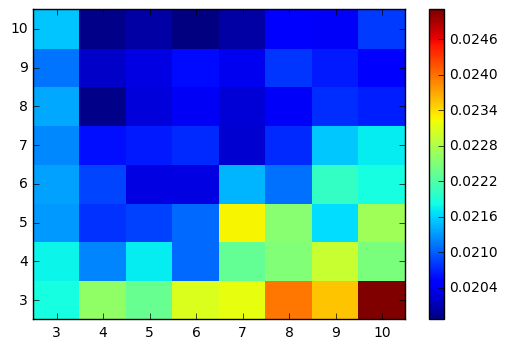

In [356]:
def heatmap(df, xticks, yticks):
    fig, ax = plt.subplots()
    grid = plt.pcolor(df)
    ax.set_yticks(np.arange(8) + 0.5)
    ax.set_xticks(np.arange(8) + 0.5)
    ax.set_yticklabels(yticks)
    ax.set_xticklabels(xticks)
    cb = fig.colorbar(grid)
    plt.show()
    
# PART - 2.3.4 : Model Selection (Visualization)

# I tried plotted a heatmap to represent the complex tradeoff between n_estimators & max_depth,
# obtained a somewhat radiant colored mesh grid.

param_range = list(range(3, 11))
hmap_df = DataFrame(index=param_range, columns=param_range, dtype=float)
best_sc = best_n_estimator = best_max_depth = 1.0
for _, row in grid_scores.iterrows():
    sc, params = - row['mean_test_score'], row['params']
    n_estimators, max_depth = params['n_estimators'], params['max_depth']
    hmap_df.loc[n_estimators, max_depth] = sc
    if sc < best_sc:
        best_sc = sc
        best_n_estimator, best_max_depth = n_estimators, max_depth

# PART - 2.3.5 : Summary
print('\n(1) Optimal n_estimators = {:d}, optimal max_depth = {:d}, optimal MSE = {:f}'
      .format(best_n_estimator, best_max_depth, best_sc))

model_forest = RandomForestRegressor(
    n_estimators=best_n_estimator, max_depth=best_max_depth, oob_score=True)
model_forest.fit(X_train.loc[:, ranked_features[:opt_n_feature]], y_train)
print('(2) Forest Model Out-of-bag Score: {:f}\n'.format(model_forest.oob_score_))

pred_rank_rf = [pname for pname, coef in sorted(
    zip(ranked_features[:opt_n_feature], model_forest.feature_importances_), 
    key=lambda x: abs(x[1]), reverse=True)][:10]
print('\n(3) 10 Most Important Predictors (descending):\n\t', pred_rank_rf)

heatmap(hmap_df, param_range, param_range)

# The basic random forest model achieves a MSE = 2.58e-2, 
# while after trying out different selection of max_depth & n_estimators & features, 
# we settle down on using n_estimator=10, max_depth=6, 
# with 38 relevant features as printed below,
# achieved a better MSE at 1.99e-2.
# Other attributes such as most important features & OOB score are printed below.

MSE of Gradient Boosting: 0.0203570411922


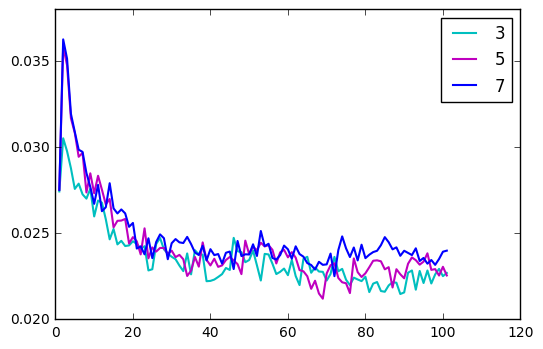


Optimal n_feature = 69, optimal MSE = 0.021204


In [257]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
mse_gb = mean_squared_error(y_test, model_gb.predict(X_test))
print('MSE of Gradient Boosting:', mse_gb)

opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for mdepth, color in ((3, 'c'), (5, 'm'), (7, 'b')):
    estimator = GradientBoostingRegressor(learning_rate=0.5, max_depth=mdepth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=3).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(mdepth))
plt.legend(loc='upper right')
plt.show()
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))

In [277]:
parameters = {'learning_rate': [0.1, 0.2, 0.5, 1, 2], 'max_depth': range(3, 7)}
clf = GridSearchCV(GradientBoostingRegressor(), parameters, scoring=NMSE, cv=5)
columns = ranked_features[:opt_n_feature]
clf.fit(X_train.loc[:, columns], y_train)
grid_scores = DataFrame(clf.cv_results_)[['rank_test_score', 'mean_test_score', 'params']]

Grid Search Scores:
     rank_test_score  mean_test_score                                  params
0                 2         0.018415  {'learning_rate': 0.1, 'max_depth': 3}
1                 1         0.018245  {'learning_rate': 0.1, 'max_depth': 4}
2                 3         0.018672  {'learning_rate': 0.1, 'max_depth': 5}
3                 4         0.018796  {'learning_rate': 0.1, 'max_depth': 6}
4                 7         0.019328  {'learning_rate': 0.2, 'max_depth': 3}
5                 6         0.019300  {'learning_rate': 0.2, 'max_depth': 4}
6                 5         0.019215  {'learning_rate': 0.2, 'max_depth': 5}
7                 8         0.019915  {'learning_rate': 0.2, 'max_depth': 6}
8                 9         0.022737  {'learning_rate': 0.5, 'max_depth': 3}
9                10         0.023754  {'learning_rate': 0.5, 'max_depth': 4}
10               12         0.024439  {'learning_rate': 0.5, 'max_depth': 5}
11               11         0.024234  {'learning_rate':

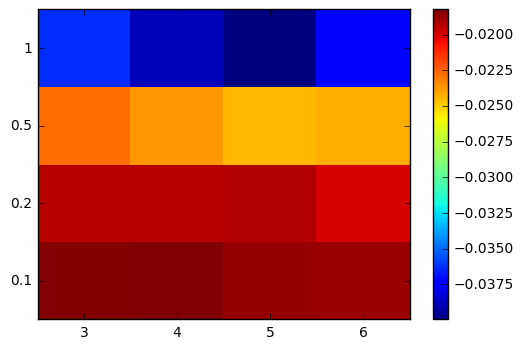


Optimal learning_rate = 0.018245, optimal max_depth = 0.100000, optimal MSE = 4


In [321]:
def heatmap2(df, xticks, yticks):
    fig, ax = plt.subplots()
    grid = plt.pcolor(df)
    ax.set_yticks(np.arange(4) + 0.5)
    ax.set_xticks(np.arange(4) + 0.5)
    ax.set_yticklabels(yticks)
    ax.set_xticklabels(xticks)
    cb = fig.colorbar(grid)
    plt.show()

grid_scores['mean_test_score'] = - grid_scores['mean_test_score']
print('Grid Search Scores:\n', grid_scores)

hmap_df = DataFrame(index=[0.1, 0.2, 0.5, 1], columns=range(3, 7), dtype=float)
best_sc = best_n_estimator = best_max_depth = 1.0
for _, row in grid_scores.iterrows():
    params = row['params']
    learning_rate, max_depth = params['learning_rate'], params['max_depth']
    if learning_rate < 2.0:
        hmap_df.loc[learning_rate, max_depth] = - row['mean_test_score']

heatmap2(hmap_df, range(3, 7), [0.1, 0.2, 0.5, 1])
best_row_selector = grid_scores['rank_test_score'] == 1
opt_mse = grid_scores.loc[best_row_selector, 'mean_test_score'].values[0]
params = grid_scores.loc[best_row_selector, 'params'].values[0]
print('\nOptimal learning_rate = {:f}, optimal max_depth = {:f}, '
      'optimal MSE = {:d}'.format(opt_mse, params['learning_rate'], params['max_depth']))

In [5]:
# Part-III

Estimated Test MSE: 0.018972


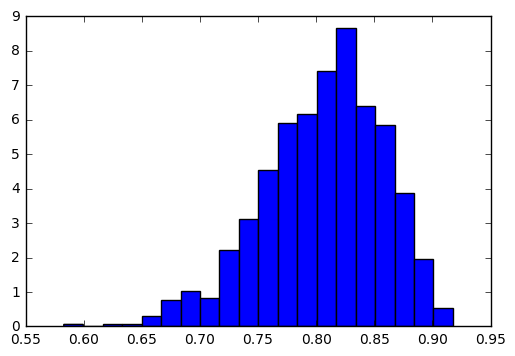

90% Confidential Interval: (0.7168288187074033, 0.8842050174183975)
